## Imports

In [25]:
import os
import platform
import random
import kagglehub
import mlflow
import mlflow.pytorch
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm # Needed for tqdm in Jupyter Notebook (Certain cell outputs will complain if this is not included)
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import ResNet18_Weights

## Hyperparameters Options

In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EXPERIMENT_NAME = "fire-smoke-detection-resnet-tuning"
SEED = 42
NUM_EPOCHS = 10
NUM_TRIALS = 1
BATCH_SIZE_OPTIONS = [16, 32, 64, 128]
LEARNING_RATE_OPTIONS = [1e-4, 1e-3, 1e-2]
WEIGHT_DECAY_OPTIONS = [1e-6, 1e-5, 1e-4]
EARLY_STOP_PATIENCE = 3

## Download Dataset

In [27]:
DATASET_PATH = kagglehub.dataset_download("sayedgamal99/smoke-fire-detection-yolo")

## Data Augmentation Options
Input images are expected to be 224x224

In [28]:
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

EVAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Construct Custom Dataset
The original dataset is structure as such:
- []  = 'No Smoke and No Fire'
- 0 = 'Smoke Only'
- 1 = 'Fire and Smoke'

The custom dataset modifies this as such:
- 0 = 'No Smoke and No Fire'
- 1 = 'Smoke Only'
- 2 = 'Fire and Smoke'

In [29]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace(".jpg", ".txt"))

        image = Image.open(img_path).convert("RGB")
        with open(label_path, "r") as f:
            label_content = f.read().strip()

        # 0: none, 1: smoke, 2: fire
        if not label_content:
            label = 0
        else:
            first_number = int(label_content.split()[0])
            label = 1 if first_number == 0 else 2

        if self.transform:
            image = self.transform(image)

        return image, label

## Training Code
The training parameters are provided by the Optuna Trails

In [30]:
def train_with_params(params: dict, train_dataset, val_dataset, test_dataset) -> float:
    """
    Train the model using the provided parameters and datasets.
    Returns the best validation loss.
    """
    
    batch_size = params["batch_size"]
    learning_rate = params["learning_rate"]
    weight_decay = params["weight_decay"]
    num_epochs = params["num_epochs"]
    early_stop_patience = params["early_stop_patience"]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = DEVICE
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)

    run_name = f"bs{batch_size}_lr{learning_rate:.0e}_wd{weight_decay:.0e}"
    with mlflow.start_run(nested=True, run_name=run_name):
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("weight_decay", weight_decay)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("early_stop_patience", early_stop_patience)
        mlflow.log_param("optimizer", optimizer.__class__.__name__)
        mlflow.log_param("scheduler", scheduler.__class__.__name__)
        mlflow.log_param("platform", platform.platform())
        mlflow.log_param("python_version", platform.python_version())
        print("Starting training...")
        print(f"Batch size: {batch_size}")
        print(f"Learning rate: {learning_rate}")
        print(f"Weight decay: {weight_decay}")
        print(f"Number of epochs: {num_epochs}")
        print(f"Early stop patience: {early_stop_patience}")
        print(f"Optimizer: {optimizer.__class__.__name__}")
        print(f"Scheduler: {scheduler.__class__.__name__}")

        best_val_loss = float('inf')
        best_model_state = None
        best_epoch = -1
        epochs_no_improve = 0
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for batch_idx, (inputs, labels) in enumerate(train_loader, 1):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_losses.append(loss.item())
                mlflow.log_metric("batch_training_loss", loss.item(), step=epoch * len(train_loader) + batch_idx)

            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    v_loss = criterion(val_outputs, val_labels)
                    val_loss += v_loss.item()
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_correct += (val_predicted == val_labels).sum().item()
                    val_total += val_labels.size(0)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            val_accuracy = val_correct / val_total if val_total > 0 else 0
            mlflow.log_metric("training_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("validation_loss", avg_val_loss, step=epoch)
            mlflow.log_metric("validation_accuracy", val_accuracy, step=epoch)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "best_val_loss": best_val_loss,
            }
            checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
            torch.save(checkpoint, checkpoint_path)
            mlflow.log_artifact(checkpoint_path)
            os.remove(checkpoint_path)

            if avg_val_loss < best_val_loss:
                epochs_no_improve = 0
                best_model_state = model.state_dict()
                best_val_loss = avg_val_loss
                best_epoch = epoch
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stop_patience:
                    break

            scheduler.step(avg_val_loss)
            best_val_accuracy = max(val_losses)
            mlflow.log_metric("best_val_accuracy", best_val_accuracy)
            mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)

        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            best_checkpoint = {
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "best_val_loss": best_val_loss,
            }
            torch.save(best_checkpoint, "best_model.pth")
            mlflow.log_artifact("best_model.pth")
            os.remove("best_model.pth")

        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                loss = criterion(outputs, test_labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == test_labels).sum().item()
                test_total += test_labels.size(0)
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = test_correct / test_total if test_total > 0 else 0
        mlflow.log_metric("test_loss", avg_test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Plot the confusion matrix
        y_true, y_pred = [], []
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(test_labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Test Confusion Matrix")
        plt.tight_layout()
        plt.savefig("test_confusion_matrix.png")
        plt.show()
        mlflow.log_artifact("test_confusion_matrix.png")
        plt.close()
        os.remove("test_confusion_matrix.png")

        # Calculate average training loss per epoch
        num_batches_per_epoch = len(train_loader)
        train_loss_per_epoch = [
            np.mean(train_losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(len(val_losses))
        ]

        # Plot training loss per epoch
        plt.figure()
        plt.plot(range(1, len(train_loss_per_epoch) + 1), train_loss_per_epoch, marker="o", label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss per Epoch")
        plt.legend()
        plt.tight_layout()
        plt.savefig("training_loss_per_epoch.png")
        plt.show()
        mlflow.log_artifact("training_loss_per_epoch.png")
        plt.close()
        os.remove("training_loss_per_epoch.png")

        # Plot validation loss per epoch
        plt.figure()
        plt.plot(range(1, len(val_losses) + 1), val_losses, marker="o", color="orange", label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Validation Loss per Epoch")
        plt.legend()
        plt.tight_layout()
        plt.savefig("validation_loss_per_epoch.png")
        plt.show()
        mlflow.log_artifact("validation_loss_per_epoch.png")
        plt.close()
        os.remove("validation_loss_per_epoch.png")

        return best_val_loss

## Experiment and Trails Set-Up

In [31]:
def objective(trial, train_dataset, val_dataset, test_dataset):
    params = {
        "batch_size": trial.suggest_categorical("batch_size", BATCH_SIZE_OPTIONS),
        "learning_rate": trial.suggest_float("learning_rate", LEARNING_RATE_OPTIONS[0], LEARNING_RATE_OPTIONS[-1]),
        "weight_decay": trial.suggest_float("weight_decay", WEIGHT_DECAY_OPTIONS[0], WEIGHT_DECAY_OPTIONS[-1], log=True),
        "num_epochs": NUM_EPOCHS,
        "early_stop_patience": EARLY_STOP_PATIENCE,
    }
    return train_with_params(params, train_dataset, val_dataset, test_dataset)

def start_experiment():
    # Set seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # Load training dataset
    train_dataset = CustomDataset(
        images_dir= os.path.join(DATASET_PATH, "data/train/images"),
        labels_dir= os.path.join(DATASET_PATH, "data/train/labels"),
        transform=TRAIN_TRANSFORM
    )

    # Load validation dataset
    val_dataset = CustomDataset(
        images_dir= os.path.join(DATASET_PATH, "data/val/images"),
        labels_dir= os.path.join(DATASET_PATH, "data/val/labels"),
        transform=EVAL_TRANSFORM
    )

    # Load test dataset
    test_dataset = CustomDataset(
        images_dir= os.path.join(DATASET_PATH, "data/test/images"),
        labels_dir= os.path.join(DATASET_PATH, "data/test/labels"),
        transform=EVAL_TRANSFORM
    )

    # Create study
    study = optuna.create_study(direction="minimize", study_name=EXPERIMENT_NAME)
    mlflow.set_experiment(EXPERIMENT_NAME)
    study.optimize(
        lambda trial: objective(trial, train_dataset, val_dataset, test_dataset),
        n_trials=NUM_TRIALS
    )

    # Print best trial
    print("Best trial:")
    print(f"  Value (best validation loss): {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")

    # Log best trial info with MLflow
    mlflow.log_metric("best_val_loss", study.best_trial.value)
    for key, value in study.best_trial.params.items():
        mlflow.log_param(f"best_{key}", value)

## Start the Experiment

[I 2025-04-28 20:37:20,569] A new study created in memory with name: fire-smoke-detection-resnet-tuning


Starting training...
Batch size: 128
Learning rate: 0.004840004649523287
Weight decay: 3.0846377146227715e-06
Number of epochs: 10
Early stop patience: 3
Optimizer: Adam
Scheduler: ReduceLROnPlateau
Epoch 1/10, Training Loss: 0.9562, Validation Loss: 1.0056, Validation Accuracy: 0.5115
Epoch 2/10, Training Loss: 0.7917, Validation Loss: 1.0393, Validation Accuracy: 0.5073
Epoch 3/10, Training Loss: 0.6925, Validation Loss: 0.7461, Validation Accuracy: 0.6592
Epoch 4/10, Training Loss: 0.6646, Validation Loss: 0.8331, Validation Accuracy: 0.6299
Epoch 5/10, Training Loss: 0.5825, Validation Loss: 0.6321, Validation Accuracy: 0.7128
Epoch 6/10, Training Loss: 0.5476, Validation Loss: 0.6347, Validation Accuracy: 0.7131
Epoch 7/10, Training Loss: 0.5006, Validation Loss: 0.6384, Validation Accuracy: 0.6957
Epoch 8/10, Training Loss: 0.4027, Validation Loss: 0.4289, Validation Accuracy: 0.8319
Epoch 9/10, Training Loss: 0.3574, Validation Loss: 0.4156, Validation Accuracy: 0.8309
Epoch 10/

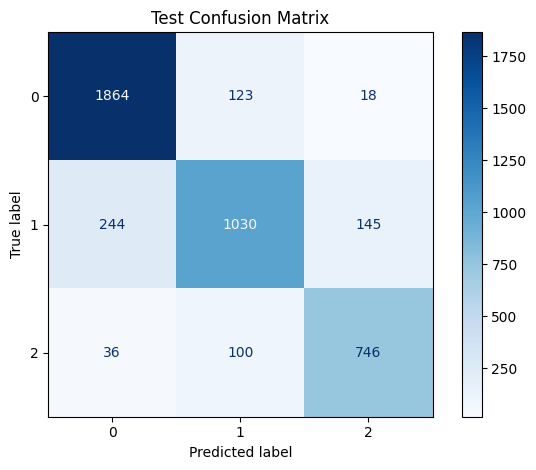

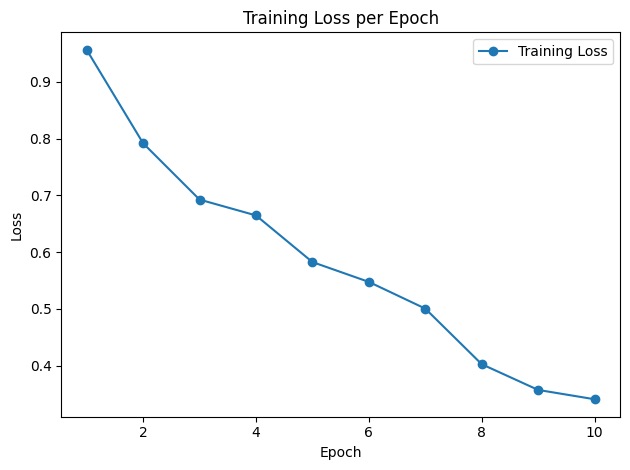

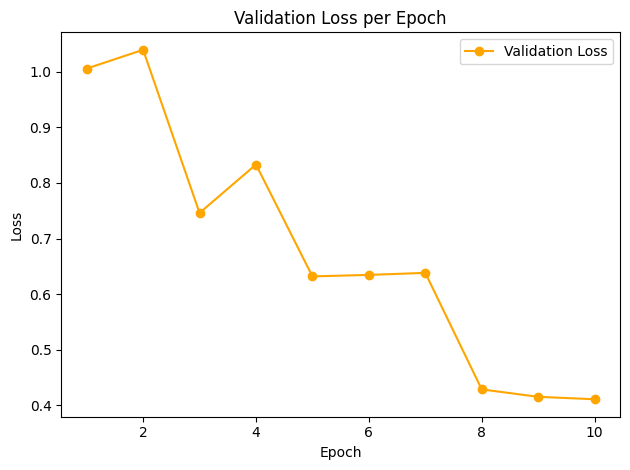

[I 2025-04-28 20:58:08,042] Trial 0 finished with value: 0.41120924927294256 and parameters: {'batch_size': 128, 'learning_rate': 0.004840004649523287, 'weight_decay': 3.0846377146227715e-06}. Best is trial 0 with value: 0.41120924927294256.


Best trial:
  Value (best validation loss): 0.41120924927294256
  Params: 
    batch_size: 128
    learning_rate: 0.004840004649523287
    weight_decay: 3.0846377146227715e-06


In [32]:
start_experiment()